<a href="https://colab.research.google.com/github/yohanesnuwara/PetroRAG/blob/main/notebooks/Generate_Finetuning_Dataset_ColPali_Norwegian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: This notebook need to use GPU A100 to run the Flash Attention mode for Qwen


## 1 - Setup environment

In [ ]:
%pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 106.6 MB/s eta 0:00:00


In [ ]:
!uv pip install accelerate qwen-vl-utils torchvision torch datasets huggingface_hub[hf_transfer] polars --system
!uv pip install git+https://github.com/huggingface/transformers.git  --system

Using Python 3.10.12 environment at: /usr
Resolved 47 packages in 526ms
⠙ Preparing packages... (0/8)
⠙ Preparing packages... (0/8)
⠙ Preparing packages... (0/8)
⠙ Preparing packages... (0/8)
⠙ Preparing packages... (0/8)
⠙ Preparing packages... (0/8)
dill       ------------------------------ 64.00 KiB/113.53 KiB
⠙ Preparing packages... (0/8)
dill       ------------------------------ 64.00 KiB/113.53 KiB
⠙ Preparing packages... (0/8)
dill       ------------------------------ 80.00 KiB/113.53 KiB
⠙ Preparing packages... (0/8)
dill       ------------------------------ 96.00 KiB/113.53 KiB
⠙ Preparing packages... (0/8)
dill       ------------------------------ 96.00 KiB/113.53 KiB
fsspec     ------------------------------ 14.88 KiB/175.05 KiB
⠙ Preparing packages... (0/8)
dill       ------------------------------ 96.00 KiB/113.53 KiB
multiprocess ------------------------------     0 B/131.66 KiB
fsspec     ------------------------------ 14.88 KiB/175.05 KiB
⠙ Preparing packages... (0/8)
d

In [ ]:
!uv pip install flash-attn --no-build-isolation --system

Using Python 3.10.12 environment at: /usr
Resolved 11 packages in 583ms
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Building flash-attn==2.7.2.post1
Buil

In [ ]:
prompt = """
You are an assistant specialized in Multimodal RAG tasks.

The task is the following: given an image from a pdf page, you will have to generate questions that can be asked by a user to retrieve information from a large documentary corpus.

The question should be relevant to the page, and should not be too specific or too general. The question should be about the subject of the page, and the answer needs to be found in the page.

Remember that the question is asked by a user to get some information from a large documentary corpus that contains multimodal data. Generate a question that could be asked by a user without knowing the existence and the content of the corpus.

Generate as well the answer to the question, which should be found in the page. And the format of the answer should be a list of words answering the question.

Generate at most THREE pairs of questions and answers per page in a dictionary with the following format, answer ONLY this dictionary NOTHING ELSE:

{
    "questions": [
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        }
    ]
}
where XXXXXX is the question and ['YYYYYY'] is the corresponding list of answers that could be as long as needed.

Note: If there are no questions to ask about the page, return an empty list. Focus on making relevant questions concerning the page.

Here is the page:"""

## 2 - Retrieve PDF image data from HuggingFace

I use this book titled "Olje og Gass fra Felt til Raffineri", a book on oil and gas in written in Norwegian.

First I download it and use [PDF to Page Images](https://huggingface.co/spaces/Dataset-Tools/pdf-to-page-images-dataset) to convert to page images, and push to my HuggingFace

The data is [here](https://huggingface.co/datasets/ynuwara/norsk-olje-gass-LLM), and now I retrieve it

In [ ]:
import os
from datasets import load_dataset

In [ ]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
ds = load_dataset("ynuwara/norsk-olje-gass-LLM", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/236 [00:00<?, ?it/s]

norsk olje gass book.pdf_page_107.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_112.jpg:   0%|          | 0.00/76.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_105.jpg:   0%|          | 0.00/36.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_111.jpg:   0%|          | 0.00/49.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_100.jpg:   0%|          | 0.00/94.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_106.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_1.jpg:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_110.jpg:   0%|          | 0.00/57.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_101.jpg:   0%|          | 0.00/84.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_11.jpg:   0%|          | 0.00/90.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_10.jpg:   0%|          | 0.00/83.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_109.jpg:   0%|          | 0.00/66.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_108.jpg:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_102.jpg:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_103.jpg:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_104.jpg:   0%|          | 0.00/99.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_114.jpg:   0%|          | 0.00/64.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_115.jpg:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_125.jpg:   0%|          | 0.00/80.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_119.jpg:   0%|          | 0.00/53.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_126.jpg:   0%|          | 0.00/62.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_124.jpg:   0%|          | 0.00/60.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_116.jpg:   0%|          | 0.00/96.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_121.jpg:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_117.jpg:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_120.jpg:   0%|          | 0.00/72.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_122.jpg:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_12.jpg:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_113.jpg:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_123.jpg:   0%|          | 0.00/76.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_118.jpg:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_128.jpg:   0%|          | 0.00/62.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_127.jpg:   0%|          | 0.00/78.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_129.jpg:   0%|          | 0.00/84.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_132.jpg:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_139.jpg:   0%|          | 0.00/81.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_135.jpg:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_131.jpg:   0%|          | 0.00/94.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_130.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_140.jpg:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_14.jpg:   0%|          | 0.00/71.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_136.jpg:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_13.jpg:   0%|          | 0.00/60.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_137.jpg:   0%|          | 0.00/66.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_134.jpg:   0%|          | 0.00/57.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_133.jpg:   0%|          | 0.00/48.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_138.jpg:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_142.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_143.jpg:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_141.jpg:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_144.jpg:   0%|          | 0.00/80.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_151.jpg:   0%|          | 0.00/82.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_148.jpg:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_146.jpg:   0%|          | 0.00/80.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_15.jpg:   0%|          | 0.00/72.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_147.jpg:   0%|          | 0.00/50.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_145.jpg:   0%|          | 0.00/55.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_149.jpg:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_154.jpg:   0%|          | 0.00/54.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_150.jpg:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_155.jpg:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_152.jpg:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_153.jpg:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_156.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_158.jpg:   0%|          | 0.00/66.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_159.jpg:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_157.jpg:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_160.jpg:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_16.jpg:   0%|          | 0.00/71.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_161.jpg:   0%|          | 0.00/47.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_168.jpg:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_166.jpg:   0%|          | 0.00/49.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_165.jpg:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_167.jpg:   0%|          | 0.00/67.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_163.jpg:   0%|          | 0.00/50.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_164.jpg:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_169.jpg:   0%|          | 0.00/48.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_162.jpg:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_17.jpg:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_171.jpg:   0%|          | 0.00/91.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_172.jpg:   0%|          | 0.00/78.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_170.jpg:   0%|          | 0.00/51.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_175.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_173.jpg:   0%|          | 0.00/67.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_174.jpg:   0%|          | 0.00/74.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_177.jpg:   0%|          | 0.00/80.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_176.jpg:   0%|          | 0.00/75.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_178.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_184.jpg:   0%|          | 0.00/84.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_179.jpg:   0%|          | 0.00/48.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_18.jpg:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_187.jpg:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_185.jpg:   0%|          | 0.00/81.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_180.jpg:   0%|          | 0.00/39.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_186.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_182.jpg:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_181.jpg:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_183.jpg:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_190.jpg:   0%|          | 0.00/60.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_188.jpg:   0%|          | 0.00/72.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_19.jpg:   0%|          | 0.00/81.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_189.jpg:   0%|          | 0.00/91.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_191.jpg:   0%|          | 0.00/91.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_192.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_193.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_196.jpg:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_2.jpg:   0%|          | 0.00/42.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_198.jpg:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_194.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_200.jpg:   0%|          | 0.00/91.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_195.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_197.jpg:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_20.jpg:   0%|          | 0.00/56.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_199.jpg:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_207.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_204.jpg:   0%|          | 0.00/93.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_201.jpg:   0%|          | 0.00/99.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_205.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_202.jpg:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_203.jpg:   0%|          | 0.00/83.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_21.jpg:   0%|          | 0.00/79.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_209.jpg:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_212.jpg:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_213.jpg:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_215.jpg:   0%|          | 0.00/65.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_210.jpg:   0%|          | 0.00/71.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_214.jpg:   0%|          | 0.00/37.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_206.jpg:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_208.jpg:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_211.jpg:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_218.jpg:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_217.jpg:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_219.jpg:   0%|          | 0.00/45.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_22.jpg:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_216.jpg:   0%|          | 0.00/55.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_220.jpg:   0%|          | 0.00/45.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_221.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_222.jpg:   0%|          | 0.00/80.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_225.jpg:   0%|          | 0.00/71.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_226.jpg:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_224.jpg:   0%|          | 0.00/53.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_227.jpg:   0%|          | 0.00/88.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_228.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_223.jpg:   0%|          | 0.00/64.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_23.jpg:   0%|          | 0.00/89.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_229.jpg:   0%|          | 0.00/91.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_234.jpg:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_230.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_232.jpg:   0%|          | 0.00/66.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_233.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_231.jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_236.jpg:   0%|          | 0.00/52.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_235.jpg:   0%|          | 0.00/71.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_3.jpg:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_24.jpg:   0%|          | 0.00/77.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_27.jpg:   0%|          | 0.00/89.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_34.jpg:   0%|          | 0.00/58.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_28.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_30.jpg:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_26.jpg:   0%|          | 0.00/88.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_36.jpg:   0%|          | 0.00/80.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_32.jpg:   0%|          | 0.00/79.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_29.jpg:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_33.jpg:   0%|          | 0.00/78.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_25.jpg:   0%|          | 0.00/64.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_31.jpg:   0%|          | 0.00/70.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_35.jpg:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_37.jpg:   0%|          | 0.00/80.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_4.jpg:   0%|          | 0.00/72.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_38.jpg:   0%|          | 0.00/64.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_39.jpg:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_41.jpg:   0%|          | 0.00/85.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_46.jpg:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_50.jpg:   0%|          | 0.00/86.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_43.jpg:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_51.jpg:   0%|          | 0.00/45.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_42.jpg:   0%|          | 0.00/57.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_47.jpg:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_40.jpg:   0%|          | 0.00/81.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_44.jpg:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_5.jpg:   0%|          | 0.00/78.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_49.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_48.jpg:   0%|          | 0.00/62.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_45.jpg:   0%|          | 0.00/74.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_52.jpg:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_56.jpg:   0%|          | 0.00/80.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_55.jpg:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_53.jpg:   0%|          | 0.00/63.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_6.jpg:   0%|          | 0.00/82.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_54.jpg:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_60.jpg:   0%|          | 0.00/68.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_57.jpg:   0%|          | 0.00/79.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_62.jpg:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_66.jpg:   0%|          | 0.00/80.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_64.jpg:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_58.jpg:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_63.jpg:   0%|          | 0.00/85.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_65.jpg:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_59.jpg:   0%|          | 0.00/96.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_61.jpg:   0%|          | 0.00/55.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_7.jpg:   0%|          | 0.00/96.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_69.jpg:   0%|          | 0.00/96.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_71.jpg:   0%|          | 0.00/87.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_68.jpg:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_67.jpg:   0%|          | 0.00/99.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_70.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_74.jpg:   0%|          | 0.00/82.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_73.jpg:   0%|          | 0.00/52.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_72.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_75.jpg:   0%|          | 0.00/61.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_80.jpg:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_79.jpg:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_76.jpg:   0%|          | 0.00/60.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_8.jpg:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_78.jpg:   0%|          | 0.00/88.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_77.jpg:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_84.jpg:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_86.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_85.jpg:   0%|          | 0.00/61.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_82.jpg:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_81.jpg:   0%|          | 0.00/45.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_83.jpg:   0%|          | 0.00/79.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_87.jpg:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_89.jpg:   0%|          | 0.00/62.3k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_9.jpg:   0%|          | 0.00/63.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_90.jpg:   0%|          | 0.00/47.8k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_94.jpg:   0%|          | 0.00/79.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_92.jpg:   0%|          | 0.00/79.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_93.jpg:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_91.jpg:   0%|          | 0.00/52.1k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_95.jpg:   0%|          | 0.00/99.4k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_98.jpg:   0%|          | 0.00/99.2k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_96.jpg:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_97.jpg:   0%|          | 0.00/86.7k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_99.jpg:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

norsk olje gass book.pdf_page_88.jpg:   0%|          | 0.00/58.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/236 [00:00<?, ? examples/s]

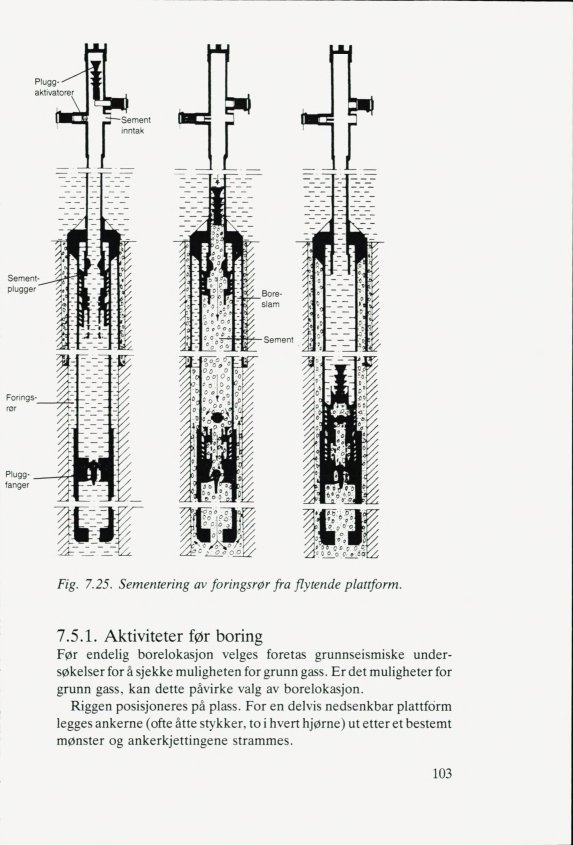

In [ ]:
ds[3]["image"]

## 3 - Using Qwen2-VL-7B-Instruct to generate queries



In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [ ]:
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

In [ ]:
text

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
inputs

{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0.8501,  0.8501,  0.8647,  ...,  1.3922,  1.3922,  1.3922],
        [ 0.9376,  0.9376,  0.9376,  ...,  1.4491,  1.4491,  1.4491],
        [ 0.9084,  0.9376,  0.9376,  ...,  1.4065,  1.4207,  1.4207],
        ...,
        [-0.1280, -0.1280, -0.1426,  ..., -0.2431, -0.2715, -0.3000],
        [-0.3324, -0.3324, -0.3032,  ..., -0.3000, -0.2715, -0.2857],
        [-0.3762, -0.4054, -0.4054,  ..., -0.4279, -0.4422, -0.4564]],
       device='cuda:0'), 'image_grid_thw': tensor([[  1,  98, 146]], device='cuda:0')}

In [1]:
# generated_ids = model.generate(**inputs, max_new_tokens=200)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# output_text

## 4 - Generate Colpali queries

```python
prompt = """
You are an assistant specialized in Multimodal RAG tasks.

The task is the following: given an image from a pdf page, you will have to generate questions that can be asked by a user to retrieve information from a large documentary corpus.

The question should be relevant to the page, and should not be too specific or too general. The question should be about the subject of the page, and the answer needs to be found in the page.

Remember that the question is asked by a user to get some information from a large documentary corpus that contains multimodal data. Generate a question that could be asked by a user without knowing the existence and the content of the corpus.

Generate as well the answer to the question, which should be found in the page. And the format of the answer should be a list of words answering the question.

Generate at most THREE pairs of questions and answers per page as JSON with the following format, answer ONLY using JSON, NOTHING ELSE:

{
    "questions": [
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        }
    ]
}

where XXXXXX is the question and ['YYYYYY'] is the corresponding list of answers that could be as long as needed.

Note: If there are no questions to ask about the page, return an empty list. Focus on making relevant questions concerning the page.

Here is the page:
"""
```

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": ds[0]["image"],
            },
            {"type": "text", "text": prompt},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=200)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_text

['{\n    "questions": [\n        {\n            "question": "What is the subject of the page?",\n            "answer": ["Olje og gass fra felt til raffineri"]\n        },\n        {\n            "question": "Who is the author of the page?",\n            "answer": ["Jan-Henrik Johnsen"]\n        },\n        {\n            "question": "What is the title of the book?",\n            "answer": ["Olje og gass fra felt til raffineri"]\n        }\n    ]\n}']

Validating the response

In [ ]:
import json

In [ ]:
json.loads(output_text[0])

{'questions': [{'question': 'What is the subject of the page?',
   'answer': ['Olje og gass fra felt til raffineri']},
  {'question': 'Who is the author of the page?',
   'answer': ['Jan-Henrik Johnsen']},
  {'question': 'What is the title of the book?',
   'answer': ['Olje og gass fra felt til raffineri']}]}

In [ ]:
print(output_text[0])

{
    "questions": [
        {
            "question": "What is the subject of the page?",
            "answer": ["Olje og gass fra felt til raffineri"]
        },
        {
            "question": "Who is the author of the page?",
            "answer": ["Jan-Henrik Johnsen"]
        },
        {
            "question": "What is the title of the book?",
            "answer": ["Olje og gass fra felt til raffineri"]
        }
    ]
}


In [ ]:
prompt = """You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving this document.

Format your response as a JSON object with the following structure:

{
  "broad_topical_query": "Your query here",
  "broad_topical_explanation": "Brief explanation",
  "specific_detail_query": "Your query here",
  "specific_detail_explanation": "Brief explanation",
  "visual_element_query": "Your query here",
  "visual_element_explanation": "Brief explanation"
}

If there are no relevant visual elements, replace the third query with another specific detail query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format."""

In [ ]:
from pydantic import BaseModel
from typing import Tuple


class GeneralRetrievalQuery(BaseModel):
    broad_topical_query: str
    broad_topical_explanation: str
    specific_detail_query: str
    specific_detail_explanation: str
    visual_element_query: str
    visual_element_explanation: str

In [ ]:
def get_retrieval_prompt(prompt_name: str) -> Tuple[str, GeneralRetrievalQuery]:
    if prompt_name != "general":
        raise ValueError("Only 'general' prompt is available in this version")

    prompt = """You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving this document.

Format your response as a JSON object with the following structure:

{
  "broad_topical_query": "Your query here",
  "broad_topical_explanation": "Brief explanation",
  "specific_detail_query": "Your query here",
  "specific_detail_explanation": "Brief explanation",
  "visual_element_query": "Your query here",
  "visual_element_explanation": "Brief explanation"
}

If there are no relevant visual elements, replace the third query with another specific detail query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format."""

    return prompt, GeneralRetrievalQuery


# Example usage:
prompt_name = "general"
prompt, pydantic_model = get_retrieval_prompt(prompt_name)
print(f"Prompt for '{prompt_name}':")
print(prompt)
print(f"\nPydantic model for this prompt: {pydantic_model}")

Prompt for 'general':
You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving 

In [ ]:
def generate_response(prompt, image):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model.generate(**inputs, max_new_tokens=200)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    return output_text

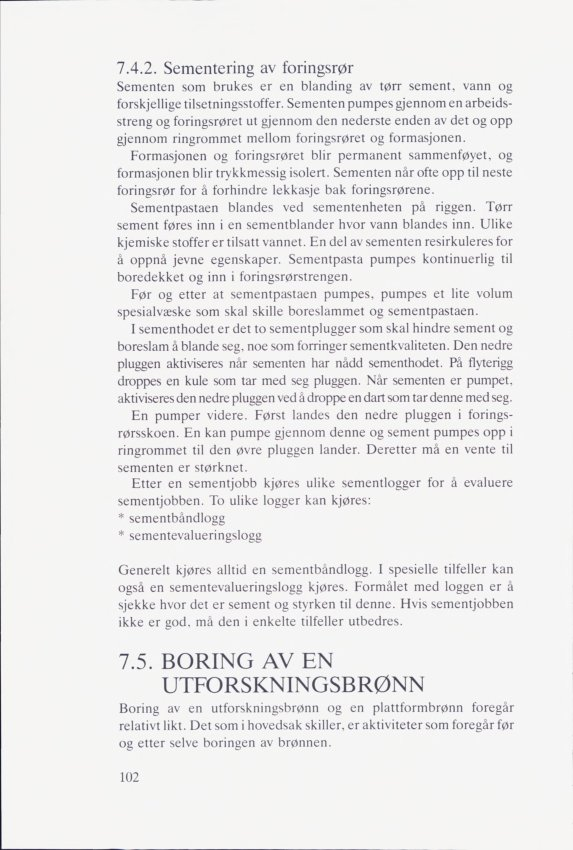

In [ ]:
ds[2]["image"]

In [ ]:
generate_response(prompt, ds[2]["image"])

['{\n  "broad_topical_query": "Document about cementing and boring in oil drilling",\n  "broad_topical_explanation": "This query covers the main subject of the document, which is about the processes of cementing and boring in oil drilling.",\n  "specific_detail_query": "Sementering av foringsrør",\n  "specific_detail_explanation": "This query focuses on a specific detail mentioned in the document, which is the cementing process for drilling.",\n  "visual_element_query": "Page 102",\n  "visual_element_explanation": "This query references the specific page number mentioned in the document, which is likely to be a unique identifier for this document page."\n}']

We can see the model does good job of generating queries.

## 5 - Generate full dataset

Here we will take 100 sample pages and build syntetic dataset for ColPali training


In [ ]:
ds

Dataset({
    features: ['image'],
    num_rows: 236
})

In [ ]:
sample = ds.take(100)

In [ ]:
from tqdm.auto import tqdm

responses = []
for row in tqdm(sample):
    try:
        resp = generate_response(prompt, row["image"])
        responses.append(resp)
    except Exception as e:
        responses.append(None)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
responses[0]

['{\n  "broad_topical_query": "Olje og gass fra felt til raffineri",\n  "broad_topical_explanation": "This query targets the main subject of the document, which is the process of oil and gas from the field to the refinery.",\n  "specific_detail_query": "Jan-Henrik Johnsen",\n  "specific_detail_explanation": "This query focuses on the author of the document, which can help in identifying the document among others.",\n  "visual_element_query": "Nasjonalbiblioteket",\n  "visual_element_explanation": "This query references the logo of the National Library, which is present on the document page and can be used to identify the document visually."\n}']

In [ ]:
# Is there any error. 0 means no bad generations
len([r for r in responses if r is None])

0

In [ ]:
responses[0][0]

'{\n  "broad_topical_query": "Olje og gass fra felt til raffineri",\n  "broad_topical_explanation": "This query targets the main subject of the document, which is the process of oil and gas from the field to the refinery.",\n  "specific_detail_query": "Jan-Henrik Johnsen",\n  "specific_detail_explanation": "This query focuses on the author of the document, which can help in identifying the document among others.",\n  "visual_element_query": "Nasjonalbiblioteket",\n  "visual_element_explanation": "This query references the logo of the National Library, which is present on the document page and can be used to identify the document visually."\n}'

In [ ]:
json.loads(responses[0][0])

{'broad_topical_query': 'Olje og gass fra felt til raffineri',
 'broad_topical_explanation': 'This query targets the main subject of the document, which is the process of oil and gas from the field to the refinery.',
 'specific_detail_query': 'Jan-Henrik Johnsen',
 'specific_detail_explanation': 'This query focuses on the author of the document, which can help in identifying the document among others.',
 'visual_element_query': 'Nasjonalbiblioteket',
 'visual_element_explanation': 'This query references the logo of the National Library, which is present on the document page and can be used to identify the document visually.'}

In [ ]:
sample = sample.add_column("raw_queries", responses)

In [ ]:
sample

Dataset({
    features: ['image', 'raw_queries'],
    num_rows: 100
})

In [ ]:
# deal with bad generations
keys = list(json.loads(responses[0][0]).keys())
keys

['broad_topical_query',
 'broad_topical_explanation',
 'specific_detail_query',
 'specific_detail_explanation',
 'visual_element_query',
 'visual_element_explanation']

In [ ]:
{k: None for k in keys}

{'broad_topical_query': None,
 'broad_topical_explanation': None,
 'specific_detail_query': None,
 'specific_detail_explanation': None,
 'visual_element_query': None,
 'visual_element_explanation': None}

## 6 - Parse to JSON

In [ ]:
def extract_data(row):
    try:
        data = json.loads(row["raw_queries"][0])
        data["parsed_into_json"] = True
        return data
    except Exception:
        data = {k: None for k in keys}
        data["parsed_into_json"] = False
        return data

We can now use the `map` method to apply this function to our dataset.

In [ ]:
parsed_ds = sample.map(extract_data)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from collections import Counter

Counter(parsed_ds["parsed_into_json"])

Counter({True: 97, False: 3})

3% of the responses were not parseable. It's still good

## 7 - Push dataset to HuggingFace Hub

I will push my created dataset to my HF hub called ynuwara/olje-gass-norsk-colpali

In [ ]:
from huggingface_hub import login

In [ ]:
# Get token and tick all the Finegrained to allow access write to repo
login()

In [ ]:
parsed_ds.push_to_hub("ynuwara/norsk-olje-gass-ColPali")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ynuwara/norsk-olje-gass-ColPali/commit/481d48baa4f439535fed6325293bc1fd47483184', commit_message='Upload dataset', commit_description='', oid='481d48baa4f439535fed6325293bc1fd47483184', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ynuwara/norsk-olje-gass-ColPali', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ynuwara/norsk-olje-gass-ColPali'), pr_revision=None, pr_num=None)

And it's done!

🤗 https://huggingface.co/datasets/ynuwara/norsk-olje-gass-ColPali 🤗